## Student Name: Shiv Patel
## Student Email: shiv.s.patel@ou.edu

# Project 3: The Smart City Slicker

Imagine you are a stakeholder in a rising Smart City and want to know more about themes and concepts about existing smart cities. You also want to know where does your smart city place among others. In this project, you will perform 
exploratory data analysis, often shortened to EDA, to examine a data from the [2015 Smart City Challenge](https://www.transportation.gov/smartcity) to find facts about the data and communicating those facts through text analysis and visualizations.

In order to explore the data and visualize it, some modifications might need to be made to the data along the way. This is often referred to as data preprocessing or cleaning.
Though data preprocessing is technically different from EDA, EDA often exposes problems with the data that need to be fixed in order to continue exploring.
Because of this tight coupling, you have to clean the data as necessary to help understand the data.

In this project, you will apply your knowledge about data cleaning, machine learning, visualizations, and databases to explore smart city applications.

**Part 1** of the notebook will explore and clean the data. \
**Part 2** will take the results of the preprocessed data to create models and visualizations.

Empty cells are code cells. 
Cells denoted with [Your Answer Here] are markdown cells.
Edit and add as many cells as needed.

Output file for this notebook is shown as a table for display purposes. Note: The city name can be Norman, OK or OK Norman.

| city | raw text | clean text | clusterid | topicids | summary | keywords|
| -- | -- | -- | -- | -- | -- | -- |
|Norman, OK | Test, test , and testing. | test test test | 0 | T1, T2| test | test |

## Introduction
The Dataset: 2015 Smart City Challenge Applicants (non-finalist).
In this project you will use the applicant's PDFs as a dataset.
The dataset is from the U.S Department of Transportation Smart City Challenge.

On the website page for the data, you can find some basic information about the challenge. This is an interesting dataset. Think of the questions that you might be able to answer! A few could be:

1. Can I identify frequently occurring words that could be removed during data preprocessing?
2. Where are the applicants from?
3. Are there multiple entries for the same city in different applicantions?
4. What are the major themes and concepts from the smart city applicants?

Let's load the data!

## Loading and Handling files

Load data from `smartcity/`. 

To extract the data from the pdf files, use the [pypdf.pdf.PdfFileReader](https://pypdf.readthedocs.io/en/stable/index.html) class.
It will allow you to extract pages and pdf files and add them to a data structure (dataframe, list, dictionary, etc).
To install the module, use the command `pipenv install pypdf`.
You only need to handle PDF files, handling docx is not necessary.

In [3]:
from pypdf import PdfReader
import os
folderPath = 'smartcity/'

pdf_files = [f for f in os.listdir(folderPath) if f.endswith('.pdf')]

Create a data structure to add the city name and raw text. You can choose to split the city name from the file.

In [4]:
import pandas as pd
dataFrame = pd.DataFrame(columns=['filename', 'text'])
i = 0
for name in pdf_files:
    x = name.endswith(".pdf")
    if x == True:
        filePath = 'smartcity/' + name
        reader = PdfReader(filePath)
        extracted_text = []

        # Iterate through each page in the PDF file
        for page_num in range(len(reader.pages)):

            page = reader.pages[page_num]
            # Extract the text from the page
            text = page.extract_text()

            # Add the extracted text to the list
            extracted_text.append(text)
        name = name[:-4]
        data_dict = {'filename': name, 'text': extracted_text}
    dataFrame = pd.concat([dataFrame, pd.DataFrame(data_dict)], ignore_index=True)

In [6]:
print(dataFrame)

           filename                                               text
0     CA Long Beach  Grant Proposal \nUSDOT SMART CITIES\nFebruary ...
1     CA Long Beach  CONTENTS\nPART I- VISION NARRATIVE\nLetters of...
2     CA Long Beach  1 THE SMART CITY CHALLENGE | CITY OF LONG BEAC...
3     CA Long Beach  2 CITY OF LONG BEACH | THE SMART CITY CHALLENG...
4     CA Long Beach  3 THE SMART CITY CHALLENGE | CITY OF LONG BEAC...
...             ...                                                ...
2061   NY Rochester  Data governance\n »Establish a Data Hub for co...
2062   NY Rochester  consistent set of standards for this challenge...
2063   NY Rochester  EVIDENCE OF \nCAPACITY\nThe City of Rochester ...
2064   NY Rochester  ExecuƟ  ve Commitment:  The City of Rochester ...
2065   NY Rochester  ROCHESTER CYCLING ALLIANCE\nIn partnership wit...

[2066 rows x 2 columns]


In [7]:
# group the rows by filename and combine the text column
df_combined = dataFrame.groupby("filename")["text"].apply(lambda x: " ".join(x)).reset_index()
print(df_combined)

             filename                                               text
0        AK Anchorage    CONTENTS \n1 VISION ...........................
1       AL Birmingham  aBirmingham\nRising\nBirmingham Rising! Meetin...
2       AL Montgomery   \n \n U.S. Department of Transportation - “BE...
3    AZ Scottsdale AZ    \n  \n \n \n \nFederal Agency Name:   U.S. D...
4           AZ Tucson  Tucson Smart City Demonstration Proposal\nPart...
..                ...                                                ...
64        VA Richmond    \n \n \n   \n \n \n  \n      Contact Informa...
65  VA Virginia Beach    \n 1.  Project Vision  ........................
66         WA Seattle  Beyond Traffic: USDOT Smart City Challenge\nAp...
67         WA Spokane  USDOT Smart City Challenge -  Spokane  \nPage ...
68         WI Madison  Building a Smart Madison  \nfor Shared Prosper...

[69 rows x 2 columns]


## Cleaning Up PDFs

One of the more frustrating aspects of PDF is loading the data into a readable format. The first order of business will be to preprocess the data. To start, you can use code provided by Text Analytics with Python, [Chapter 3](https://github.com/dipanjanS/text-analytics-with-python/blob/master/New-Second-Edition/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb): [contractions.py](https://github.com/dipanjanS/text-analytics-with-python/blob/master/New-Second-Edition/Ch05%20-%20Text%20Classification/contractions.py) (Pages 136-137), and [text_normalizer.py](https://github.com/dipanjanS/text-analytics-with-python/blob/master/New-Second-Edition/Ch05%20-%20Text%20Classification/text_normalizer.py) (Pages 155-156). Feel free to download the scripts or add the code directly to the notebook (please note this code is performed on dataframes).

In addition to the data cleaning provided by the textbook, you will need to:
1. Consider removing terms that may effect clustering and topic modeling. Words to consider are cities, states, common words (smart, city, page, etc.). Keep in mind n-gram combinations are important; this can also be revisited later depending on your model's performance.
2. Check the data to remove applicants that text was not processed correctly. Do not remove more than 15 cities from the data.


In [8]:
import nltk
import spacy
import unicodedata
import re
from nltk.corpus import wordnet
import collections
#from textblob import Word
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# nlp_vec = spacy.load('en_vectors_web_lg', parse=True, tag=True, entity=True)

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    if bool(soup.find()):
        [s.extract() for s in soup(['iframe', 'script'])]
        stripped_text = soup.get_text()
        stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    else:
        stripped_text = text
    return stripped_text


#def correct_spellings_textblob(tokens):
#	return [Word(token).correct() for token in tokens]  


def simple_porter_stemming(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text


def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
            
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens


def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]|\[|\]' if not remove_digits else r'[^a-zA-Z\s]|\[|\]'
    text = re.sub(pattern, '', text)
    return text


def remove_stopwords(text, is_lower_case=False, stopwords=stopword_list):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def remove_States(text):
    pattern = r'Alabama|Alaska|Arizona|Arkansas|California|Colorado|Connecticut|Delaware|Florida|Georgia|Hawaii|Idaho|Illinois|Indiana|Iowa|Kansas|Kentucky|Louisiana|Maine|Maryland|Massachusetts|Michigan|Minnesota|Mississippi|Missouri|Montana|Nebraska|Nevada|New\sHampshire|New\sJersey|New\sMexico|New\sYork|North\sCarolina|North\sDakota|Ohio|Oklahoma|Oregon|Pennsylvania|Rhode\sIsland|South\sCarolina|South\sDakota|Tennessee|Texas|Utah|Vermont|Virginia|Washington|West\sVirginia|Wisconsin|Wyoming|AL|AK|AZ|AR|CA|CO|CT|DE|FL|GA|HI|ID|IL|IN|IA|KS|KY|LA|ME|MD|MA|MI|MN|MS|MO|MT|NE|NV|NH|NJ|NM|NY|NC|ND|OH|OK|OR|PA|RI|SC|SD|TN|TX|UT|VT|VA|WA|WV|WI|WY'                        
    text = re.sub(pattern, '', text)
    return text

def remove_CommonWords(text):
    pattern = r"U\.S\. Department|smartcity|smart|city|page|section|element|concept|appendix"
    text = re.sub(pattern, '', text)
    return text

def remove_Cities(text):
    pattern = r'Anchorage|Birmingham|Montgomery|Scottsdale|Tucson|Chula Vista|Fremont|Fresno|Long Beach|Moreno Valley|Oakland|Oceanside|Riverside|Sacramento|San Jose_0|NewHaven|DC_0|Jacksonville|Miami|Orlando|St. Petersburg|Tallahassee|Tampa|Atlanta|Brookhaven|Des Moines|Indianapolis|Louisville|Baton Rogue|New Orleans|Shreveport|Boston|Baltimore|Detroit|Port Huron and Marysville|Minneapolis St Paul|St. Louis|Charlotte|Greensboro|Raleigh|Lincoln|Omaha|Jersey City|Newark|Las Vegas|Reno|Albany Troy Schenectady Saratoga Springs|Buffalo|Mt Vernon Yonkers New Rochelle|Rochester|Akron|Canton|Cleveland|Toledo|Oklahoma City|Tulsa|Providence|Greenville|Chattanooga|Memphis|Nashville|Lubbock|Newport News|Norfolk|Richmond|Virginia Beach|Seattle|Spokane|Madison'                        
    text = re.sub(pattern, '', text)
    return text

def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_stemming=False, text_lemmatization=True, 
                     special_char_removal=True, remove_digits=True,
                     stopword_removal=True, removeStates = True, removeCities = True,
                     removeCommonWords = True, stopwords=stopword_list):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:

        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)

        # remove extra newlines
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))

        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)

        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)

        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)

        # stem text
        if text_stemming and not text_lemmatization:
        	doc = simple_porter_stemming(doc)

        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  

        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        
        # remove states
        if removeStates:
            doc = remove_States(doc)
        
        # remove the common words
        if removeCommonWords:
            doc = remove_CommonWords(doc)

        # remove cities
        if removeCities:
            doc = remove_Cities(doc)

         # lowercase the text    
        if text_lower_case:
            doc = doc.lower()

        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case, stopwords=stopwords)
            
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [9]:
corpus = normalize_corpus(df_combined['text'])

#### Add the cleaned text to the structure you created.


In [10]:
cleaned_text = df_combined.copy()
cleaned_text['text'] = corpus

In [11]:
print(cleaned_text['text'][1])

rise rise meet challenge become americas next smart city icontents introduction city challenge opportunity vision goal approach capa commitment process risks systems data influence letter support become americas next smart city introduction william coleman jr fourth secretary transporta paint picture way society would travel interact leadership u department transporta set crea ng planning decision make framework guide future secretary colemans future become reality country seem stand li le progress make case city fast forward today leadership secretary transporta anthony foxx u department transporta develop year transporta plan na plan en tle beyond traffi c clear thesis united states need pivot away reliance car towards mobility system er suit ci es could agree city one u ci es help na achieve transporta vision city reemerge vibrant southern place people choose live business innovate grow thrive visitor seek historic cultural recrea onal experience careful comprehensive community plan

### Clean Up: Discussion
Answer the questions below.

#### Which Smart City applicants did you remove? What issues did you see with the documents?

[Your Answer Here]

#### Explain what additional text processing methods you used and why.

I used 3 functions remove_States(), remove_CommonWords(), remove_Cites() other than the ones provided in the text_normalizer.py to re which would that may effect clustering and topic modeling

#### Did you identify any potientally problematic words?

I found some problematic words looking at some of the cleaned data which are as follows:
cteure
nthern
knik
chlenge
automo
ci
es
There are many such words that don't mean anything.

## Experimenting with Clustering Models

Now, you'll start to explore models to find the optimal clustering model. In this section, you'll explore [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [Hierarchical](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), and [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN) clustering algorithms.
Create these algorithms with k_clusters for K-means and Hierarchical.
For each cell in the table provide the [Silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score), [Calinski and Harabasz score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score), and [Davies-Bouldin score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html#sklearn.metrics.davies_bouldin_score).

In each cell, create an array to store the values.
For example, 

|Algorithm| k = 9 | k = 18| k = 36 | Optimal k| 
|--|--|--|--|--|
|K-means| [S,CH,DB]| [S,CH,DB] | [S,CH,DB] | [S,CH,DB] |
|Hierarchical |[S,CH,DB]| [S,CH,DB]| [S,CH,DB] | [S,CH,DB]|
|DBSCAN | X | X | X | [S,CH,DB] |



### Optimality 
You will need to find the optimal k for K-means and Hierarchical algorithms.
Find the optimality for k in the range 2 to 50.
Provide the code used to generate the optimal k and provide justification for your approach.


|Algorithm| k = 9 | k = 18| k = 36 | Optimal k| 
|--|--|--|--|--|
|K-means|--|--|--|--|
|Hierarchical |--|--|--|--|
|DBSCAN | X | X | X | -- |



In [12]:
import bs4
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

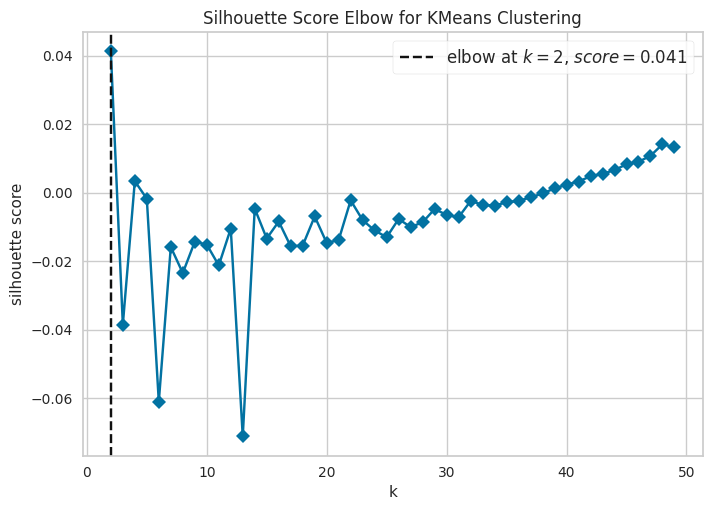

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [13]:
tfidf = TfidfVectorizer(ngram_range=(1,3))
tfidfdocs = tfidf.fit_transform(raw_documents=cleaned_text['text'])

model = KMeans(n_init='auto' ,max_iter=300)
visualizer = KElbowVisualizer(model, k = (2,50), metric = 'silhouette', timings = False)
visualizer.fit(tfidfdocs)
visualizer.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

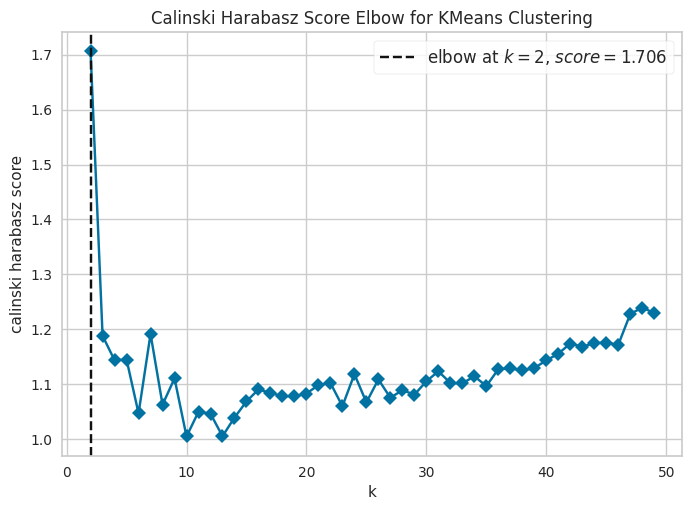

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [17]:
model = KMeans(n_init='auto' ,max_iter=300)
visualizer = KElbowVisualizer(model, k = (2,50), metric = 'calinski_harabasz', timings = False)
visualizer.fit(tfidfdocs.toarray())
visualizer.show()

#### How did you approach finding the optimal k?

[Your answer here]

#### What algorithm do you believe is the best? Why?

[Your Answer]

### Add Cluster ID to output file
In your data structure, add the cluster id for each smart city respectively. Show the to append the clusterid code below.

### Save Model

After finding the best model, it is desirable to have a way to persist the model for future use without having to retrain. Save the model using [model persistance](https://scikit-learn.org/stable/model_persistence.html). This model should be saved in the same directory as this notebook and should be loaded as the model for your `project3.py`.

Save the model as `model.pkl`. You do not have to use pickle, but be sure to save the persistance using one of the methods listed in the link.

## Derving Themes and Concepts

Perform Topic Modeling on the cleaned data. Provide the top five words for `TOPIC_NUM = Best_k` as defined in the section above. Feel free to reference [Chapter 6](https://github.com/dipanjanS/text-analytics-with-python/tree/master/New-Second-Edition/Ch06%20-%20Text%20Summarization%20and%20Topic%20Models) for more information on Topic Modeling and Summarization.

### Extract themes
Write a theme for each topic (atleast a sentence each).

[Your Answer]

[Your Answer]

[Your Answer]

### Add Topid ID to output file
Add the top two topics for each smart city to the data structure.

## Gathering Applicant Summaries and Keywords

For each smart city applicant, gather a summary and keywords that are important to that document. You can use gensim to do this. Here are examples of functions that you could use.

```python

from gensim.summarization import summarize

def summary(text, ratio=0.2, word_count=250, split=False):
    return summarize(text, ratio= ratio, word_count=word_count, split=split)
    
from gensim.summarization import keywords

def keys(text, ratio=0.01):
    return keywords(text, ratio=ratio)
```

### Add Summaries and Keywords
Add summary and keywords to output file.

## Write output data

The output data should be written as a TSV file.
You can use `to_csv` method from Pandas for this if you are using a DataFrame.

`Syntax: df.to_csv('file.tsv', sep = '')` \
`df.to_csv('smartcity_eda.tsv', sep='\t')`

# Moving Forward
Now that you have explored the dataset, take the important features and functions to create your `project3.py`.
Please refer to the project spec for more guidance.
